In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from phoenix import get_any_metallicity_url, get_phoenix_model_wavelengths
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d

In [31]:
get_any_metallicity_url(5800-1500, 4.5, 0)

'ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte04300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

In [48]:
wl_min = 4000
wl_max = 6000

phoenix_wl = get_phoenix_model_wavelengths()
phoenix_sun_fl = fits.getdata(get_any_metallicity_url(5800, 4.5, 0))

phoenix_spot_fl = fits.getdata('data/lte04300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

phoenix_sun_fl = phoenix_sun_fl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]
phoenix_sun_fl /= phoenix_sun_fl.max()

phoenix_spot_fl = phoenix_spot_fl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]
phoenix_spot_fl /= phoenix_spot_fl.max()

phoenix_wl = phoenix_wl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]

In [49]:
fs = 0.98
phoenix_mixture = fs * phoenix_sun_fl + (1 - fs) * phoenix_spot_fl

In [50]:
import astropy.units as u
#Server: Vienna VALD3 Version: 1949
vald3 = open('/Users/bmmorris/git/whoseline-vis/data/vald3longer.txt').read().splitlines() # Detection threshold : 0.5

#spectral_lines = []
species = []
wavelengths = []
strengths = []
for row in vald3[4:-150]: 
    if row.count(',') > 8:
        split_row = row.split(',')

    species.append(split_row[0][1:-1].strip())
    wavelengths.append(float(split_row[1].strip())*u.Angstrom)
    strengths.append(float(split_row[9].strip()))

species = np.array(species)
wavelengths = u.Quantity(wavelengths)
strengths = np.array(strengths)

from astropy.table import Table

table = Table(dict(species=species, wavelengths=wavelengths, strengths=strengths))

def plot_lines(line_table, axis, n_lines, line_kwargs, upper_xaxis=True):
    wl_bounds = axis.get_xlim()

    rows_within_bounds = ((line_table['wavelengths'] > wl_bounds[0]) & 
                           (line_table['wavelengths'] < wl_bounds[1]))
    
    strengths_within_bounds = line_table[rows_within_bounds]['strengths']
    
    if len(strengths_within_bounds) < n_lines:
        n_lines = len(strengths_within_bounds)
    
    condition = strengths_within_bounds >= np.sort(strengths_within_bounds)[-n_lines]

    for wavelength, strength, species in zip(line_table['wavelengths'][rows_within_bounds][condition],
                                             line_table['strengths'][rows_within_bounds][condition], 
                                             line_table['species'][rows_within_bounds][condition]):
        axis.axvline(wavelength, **line_kwargs)
        if not upper_xaxis:
            axis.annotate(species, xy=(wavelength, 1.0), rotation=30)
        
    new_ticks = line_table['wavelengths'][rows_within_bounds][condition]
    new_tick_labels = line_table['species'][rows_within_bounds][condition]
    
    if upper_xaxis:
        axis_upper = axis.twiny()

        def tick_function(x):
            return (x-wl_bounds[0])/(wl_bounds[1] - wl_bounds[0])

        axis_upper.set_xticks(tick_function(new_ticks))
        axis_upper.set_xticklabels(new_tick_labels, rotation=45, ha='left')

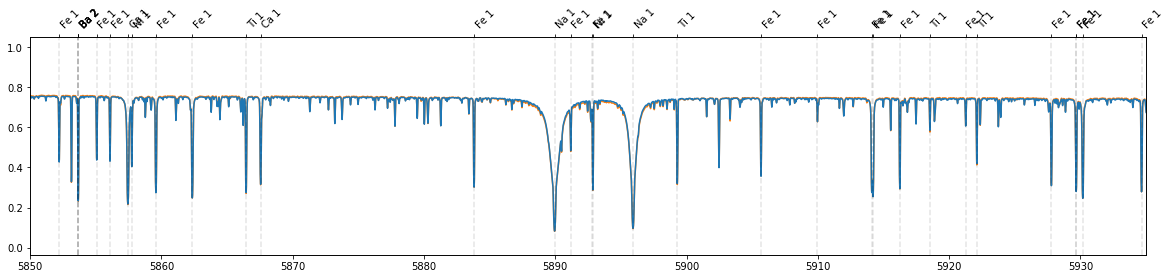

In [58]:
plt.figure(figsize=(20, 4))
plt.plot(phoenix_wl, phoenix_sun_fl)
plt.plot(phoenix_wl, phoenix_mixture, zorder=-10)
plt.xlim([5850, 5935])

# plt.xlim([4000, 4200])

axis = plt.gca()
plot_lines(table, axis, 100, dict(ls='--', color='k', alpha=0.1))

(5875, 5910)

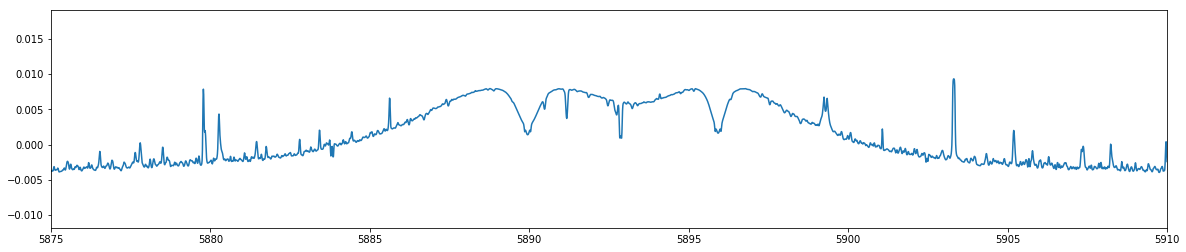

In [57]:
plt.figure(figsize=(20, 4))
plt.plot(phoenix_wl, phoenix_sun_fl - phoenix_mixture)
# plt.xlim([5190, 5200])
plt.xlim([5875, 5910])
# plt.xlim([4000, 4200])

